# Task 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following:
#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or feature. These are more relevant to developers and very seldom to analysts

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Auto show figures
%matplotlib inline

In [3]:
path= r'/Users/schitchards/Career Foundry/Achievement 6/Data'

In [4]:
df = pd.read_csv(os.path.join(path,'Prepared Data','df6_2.csv'),index_col=0)

In [5]:
df.shape

(3312, 24)

In [6]:
df.tail(5)

Order Date  Row ID    Order ID       Ship Mode  Customer ID    Segment  \
3307   20-12-30     908  2017143259  Standard Class        18865   Consumer   
3308   20-12-30     909  2017143259  Standard Class        18865   Consumer   
3309   20-12-30    1297  2017115427  Standard Class        13975  Corporate   
3310   20-12-30    1298  2017115427  Standard Class        13975  Corporate   
3311   20-12-30    5092  2017156720  Standard Class        15580   Consumer   

            Country           City       State  Postal Code  ...  \
3307  United States  New York City    New York        10009  ...   
3308  United States  New York City    New York        10009  ...   
3309  United States      Fairfield  California        94533  ...   
3310  United States      Fairfield  California        94533  ...   
3311  United States       Loveland    Colorado        80538  ...   

                                         Product Name   Sales Quantity  \
3307                        Gear Head AU3700S Headset  90.930        7   
3308             Wilson Jones Legal Size Ring Binders  52.776        3   
3309  Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl  13.904        2   
3310                               GBC Binding covers  20.720        2   
3311                              Bagged Rubber Bands   3.024        3   

     Discount   Profit    Price  Break Even Price  Month  Price category  \
3307      0.0   2.7279  12.9900           12.6003     12       Low price   
3308      0.2  19.7910  21.1104           10.9950     12       Low price   
3309      0.2   4.5188   8.3424            4.6926     12       Low price   
3310      0.2   6.4750  12.4320            7.1225     12       Low price   
3311      0.2  -0.6048   1.2096            1.2096     12       Low price   

      Profit Category  
3307           Profit  
3308           Profit  
3309           Profit  
3310           Profit  
3311             Loss  

[5 rows x 24 columns]

In [7]:
df.columns

Index(['Order Date', 'Row ID', 'Order ID', 'Ship Mode', 'Customer ID',
       'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Price', 'Break Even Price', 'Month',
       'Price category', 'Profit Category'],
      dtype='object')

### 2. Subsetting, wrangling, and cleaning time-series data

In [8]:
# Removing Unncessary columns and sorting by Order Date
cols = ['Row ID', 'Order ID', 'Ship Mode', 'Customer ID','Segment', 'Country', 'City', 'State', 'Postal Code', 'Region','Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit', 'Price', 'Break Even Price', 'Month','Price category', 'Profit Category']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Order Date')

# Check for null values
df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

I chose to keep all the series as it covers a single year and there should be no historical event bias.

In [9]:
# Set index as Order Date
dfz = df.set_index('Order Date')
dfz.index

Index(['20-1-01', '20-1-01', '20-1-01', '20-1-01', '20-1-01', '20-1-01',
       '20-1-01', '20-1-01', '20-1-01', '20-1-01',
       ...
       '20-9-29', '20-9-29', '20-9-29', '20-9-30', '20-9-30', '20-9-30',
       '20-9-30', '20-9-30', '20-9-30', '20-9-30'],
      dtype='object', name='Order Date', length=3312)

In [10]:
dfz.head(5)

Sales
Order Date         
20-1-01      48.896
20-1-01     474.430
20-1-01       3.600
20-1-01     454.560
20-1-01     141.420

In [11]:
# Reset index so that you can use the "Date" column as a filter
dfx = dfz.reset_index()
dfx.head(12)

Order Date    Sales
0     20-1-01   48.896
1     20-1-01  474.430
2     20-1-01    3.600
3     20-1-01  454.560
4     20-1-01  141.420
5     20-1-01  310.744
6     20-1-01   12.736
7     20-1-01    6.470
8     20-1-01   13.748
9     20-1-01   15.224
10    20-1-02   16.590
11    20-1-02  372.144

In [12]:
#Change date format
dfx['Date'] = pd.to_datetime(dfx['Order Date'], format='%y-%m-%d')
dfx.drop(['Order Date'], axis=1, inplace=True) # Drop the Date column.
dfx.tail()

Sales       Date
3307    3.890 2020-09-30
3308  164.880 2020-09-30
3309  159.980 2020-09-30
3310   20.664 2020-09-30
3311   11.646 2020-09-30

In [20]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312 entries, 0 to 3311
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Sales   3312 non-null   float64       
 1   Date    3312 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.9 KB


In [28]:
# Group by Month
monthly_sales=dfx.groupby(pd.Grouper(key='Date',freq='m')).sum()
monthly_sales.tail()

Sales
Date                   
2020-08-31   63120.8880
2020-09-30   87866.6520
2020-10-31   77776.9232
2020-11-30  118447.8250
2020-12-31   83829.3188

I chose to take the sum of sales by week to make it easier to work with and provide more usefull results.

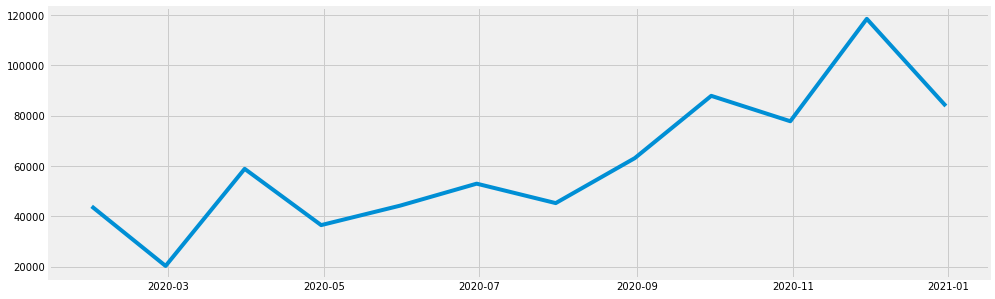

In [29]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5)) # The dpi argument controls the quality of the visualization here. When it's set to 100, it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(monthly_sales)

In [30]:
# Check for missing values (you shouldn't have any)
monthly_sales.isnull().sum()

Sales    0
dtype: int64

In [31]:
# Check for duplicates

dups = monthly_sales.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

The data does not work well with decomposition as it only has 1 year of sales and cannot compare multiple cycles to see seasonality. In order to continue using the data a quarterly period will be compared.

In [54]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive', period= 1)
decomposition2 = sm.tsa.seasonal_decompose(monthly_sales, model='additive', period= int(len(monthly_sales)/4))
# set the period to quarters since I don't have yearly values

In [50]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

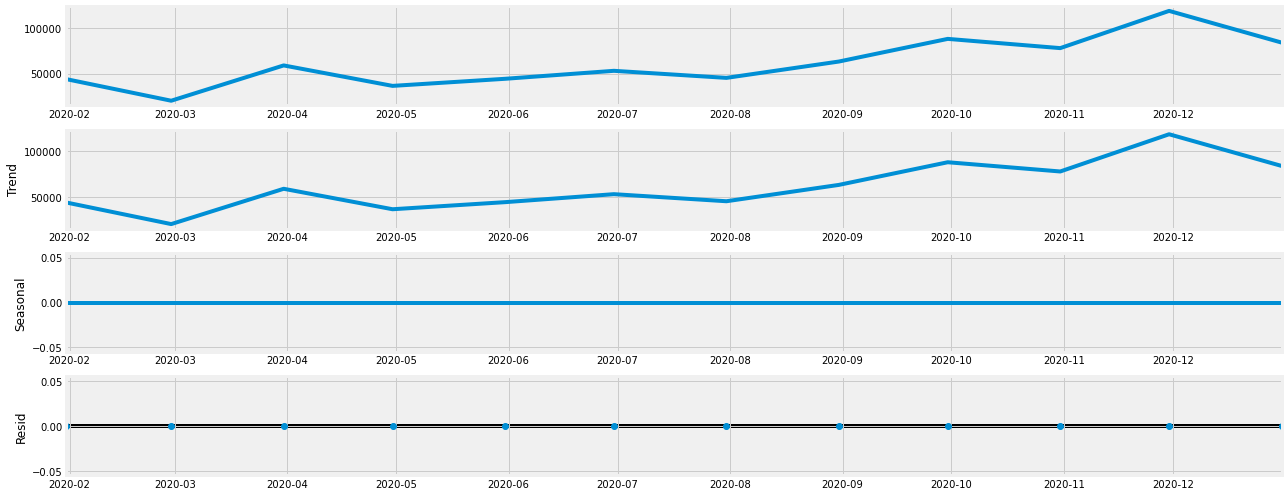

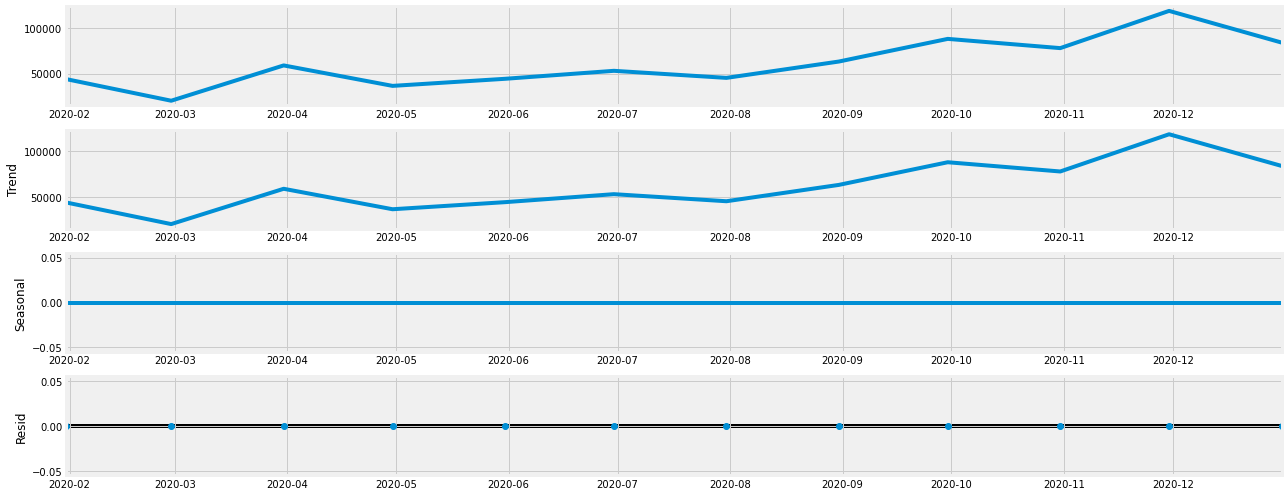

In [55]:
decomposition.plot()

Plotted only using 1 period

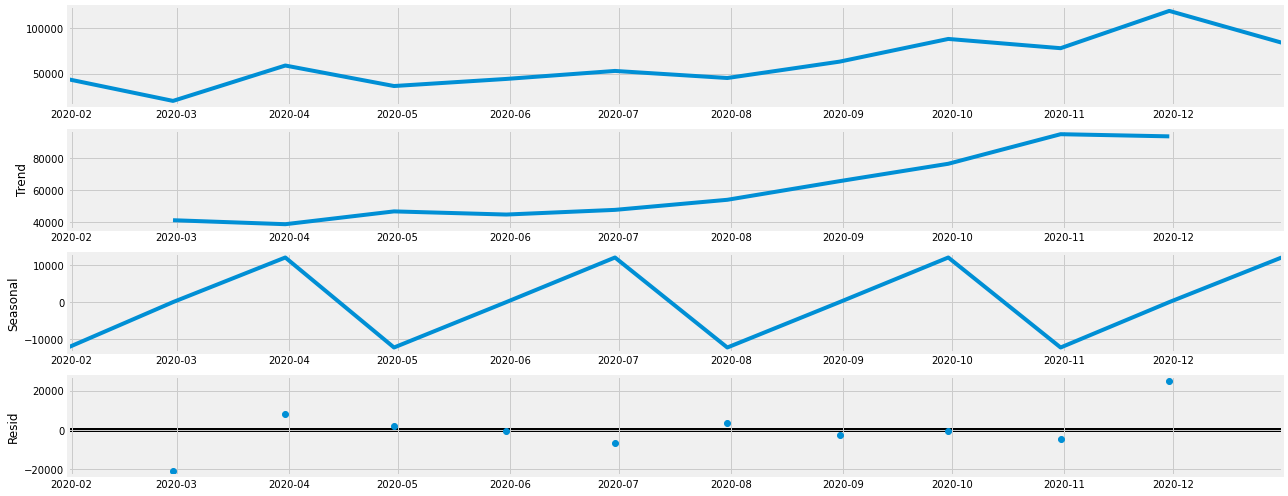

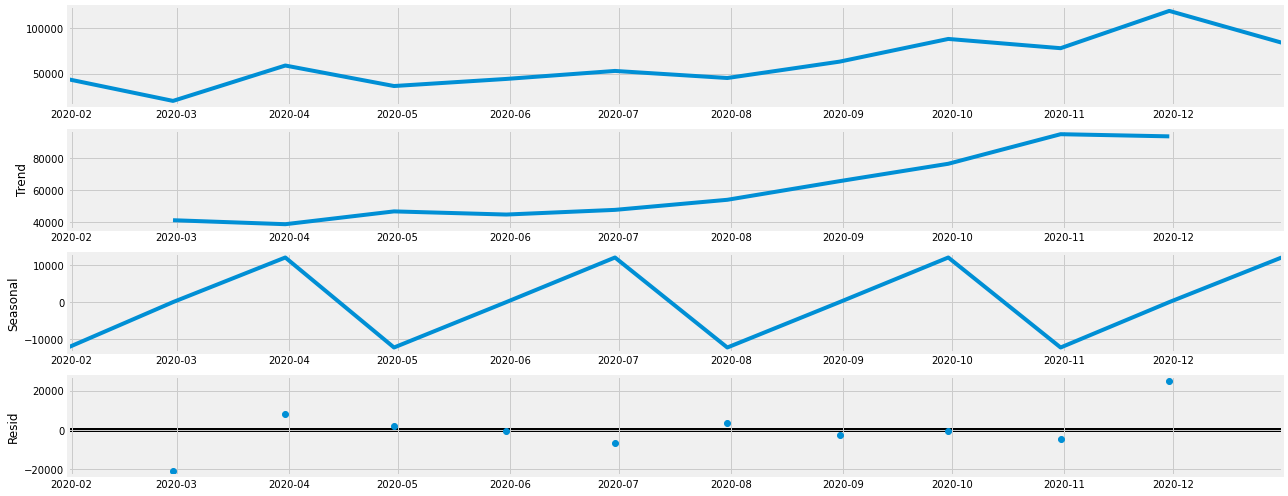

In [51]:
# Plot the separate components
decomposition2.plot()

Because the data being used is monthly rather than daily it doesnt require smoothing. This also means that the underlying trend appears to be the same as the level chart because it doesn't have much noise.

The third chart shows seasonal spikes in April, July, and October.

The presence of a trend a seasonality implies that the series is non-stationary.


### 4. Testing for stationarity

In [38]:
# The Dickey-Fuller test is a test that checks for the presence of a unit root
#i.e. a test to check whether or not the data is stationary
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_sales['Sales'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.078364
p-value                         0.964552
Number of Lags Used             1.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


P-value is nearly 1 which indicates that the result is not significant.

- Null hypothesis = The presence of a unit root
- Alternative hypothesis = No presence of a unit root.

Looking at the critical value at 5% (-3.232950) it is much smaller than the test statistic of -0.078364 which means we can't reject the null hypothesis.

This means that there is a unit root in the data, and the data is non-stationary

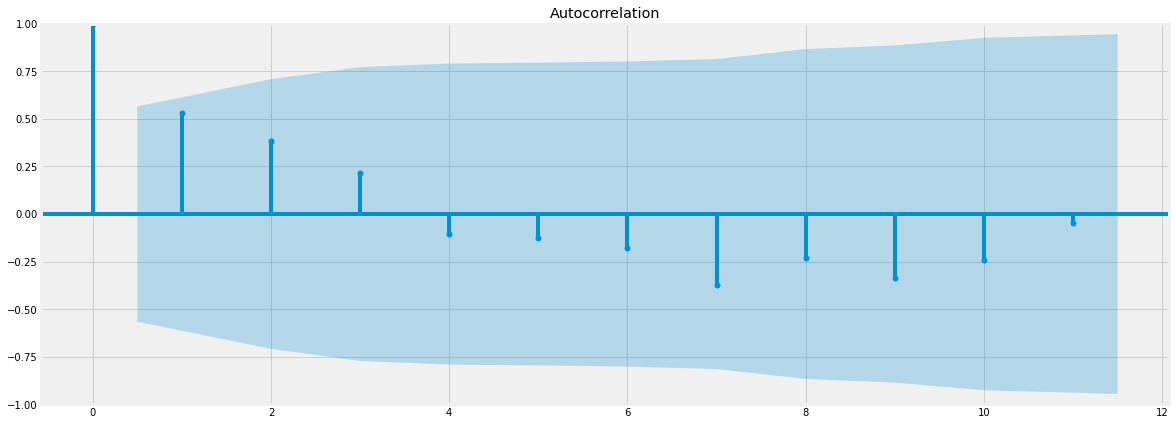

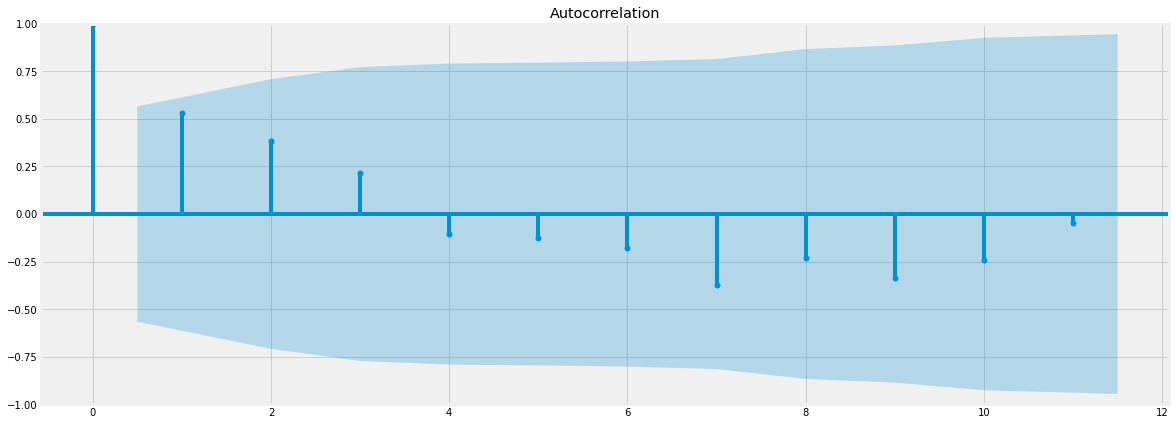

In [56]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(monthly_sales)

Due to there being a vertical line above the confidence interval we can deduce that the data is non-stationary.

### 5. Stationarizing the Data

In [57]:
data_diff = monthly_sales - monthly_sales.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [62]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing.
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [63]:
data_diff.head()

Sales
Date                  
2020-02-29 -23670.2406
2020-03-31  38571.2194
2020-04-30 -22350.8167
2020-05-31   7739.5741
2020-06-30   8720.6155

In [64]:
data_diff.columns

Index(['Sales'], dtype='object')

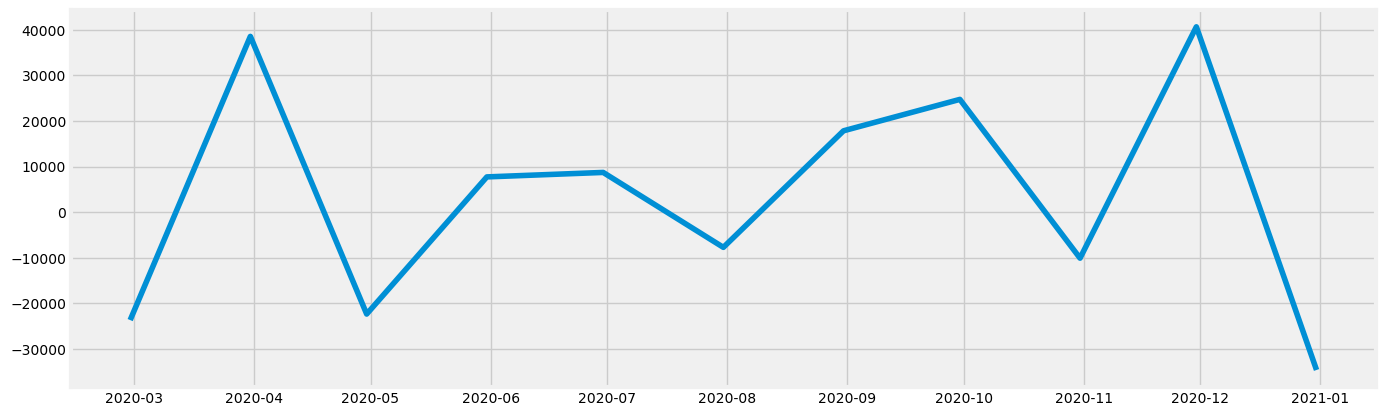

In [65]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [66]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.061680e+00
p-value                        1.636608e-12
Number of Lags Used            0.000000e+00
Number of Observations Used    1.000000e+01
Critical Value (1%)           -4.331573e+00
Critical Value (5%)           -3.232950e+00
Critical Value (10%)          -2.748700e+00
dtype: float64


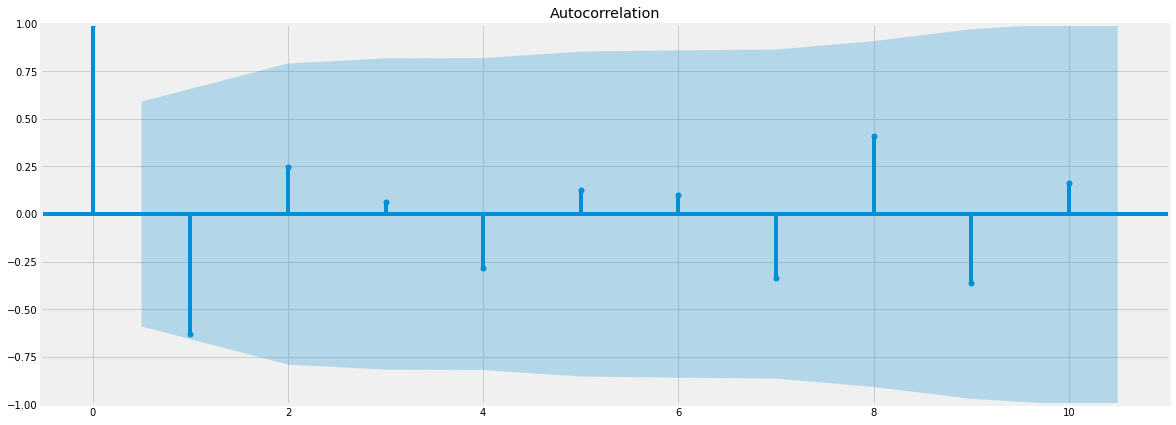

In [67]:
plot_acf(data_diff)
plt.show()